##### the goal is here to see what changes between baseline and baseline-2snaps, in an attempt to understand why i-band depth stddev is better in the latter as compared to the former.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import os
import pandas as pd
%matplotlib inline

In [2]:
import time
import copy
import numpy as np
import healpy as hp
import os
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles

import lsst.sims.maf.maps as maps

In [3]:
%matplotlib inline

In [4]:
fontsize = 18
rcparams = {}
rcparams['figure.figsize'] = (10, 6)
rcparams['axes.labelsize'] = fontsize
rcparams['legend.fontsize'] = fontsize-4
rcparams['axes.titlesize'] = fontsize
rcparams['axes.linewidth'] = 2
rcparams['axes.grid'] = True
for axis in ['x', 'y']:
    rcparams['%stick.labelsize'%axis] = fontsize-2
    rcparams['%stick.direction'%axis] = 'in'
    rcparams['%stick.major.size'%axis] = 5.5
    rcparams['%stick.minor.size'%axis] =  3.5
    rcparams['%stick.major.width'%axis] = 2
    rcparams['%stick.minor.width'%axis] = 1.5
rcparams['xtick.top'] = True
rcparams['ytick.right'] = True
for key in rcparams: mpl.rcParams[key] = rcparams[key]

In [5]:
nside = 256
area_ppixel = hp.nside2pixarea(nside=nside, degrees=True)

dbdir = '/global/cscratch1/sd/awan/dbs_post_wp_v3'

dbnames =[f for f in os.listdir(dbdir) if f.__contains__('baseline') ]
print(dbnames)
dbnames.reverse()

['baseline_2snapsv1.4_10yrs.db', 'baseline_v1.4_10yrs.db']


In [6]:
outdir = 'tests'

##### run the metrics to get statistics on the seeing

In [7]:
bundles_all = {}

In [8]:
colname = 'seeingFwhmEff'

 # consider only non-DD visits
sqlconstraint = ' note not like "DD%"'
sqlconstraint += ' and filter=="i"'

resultsDb = db.ResultsDb(outDir=outdir)

for dbname in dbnames:
    bundles = {}
    
    dbpath = '%s/%s' % (dbdir, dbname)

    opsdb = db.OpsimDatabase(dbpath)
    # set up slicer
    slicer = slicers.HealpixSlicer(lonCol='fieldRA', latCol='fieldDec',
                                   latLonDeg=opsdb.raDecInDeg, nside=nside, useCache=False)
    
    # set up the mean metric
    metric = metrics.MeanMetric(col=colname)
    # setup the bundle
    bundles['mean'] = metricBundles.MetricBundle(metric, slicer, sqlconstraint)
    
     # set up the mean metric
    metric = metrics.MedianMetric(col=colname)
    # setup the bundle
    bundles['median'] = metricBundles.MetricBundle(metric, slicer, sqlconstraint)
    
    
    # set up the mean metric
    metric = metrics.RmsMetric(col=colname)
    # setup the bundle
    bundles['rms'] = metricBundles.MetricBundle(metric, slicer, sqlconstraint)
    
    # set up the group.
    grp = metricBundles.MetricBundleGroup(bundles, opsdb, outDir=outdir,
                                          resultsDb=resultsDb, saveEarly=False)
    grp.runAll()

    for key in bundles:
        bundles_all['%s - %s' % (dbname.split('.db')[0], key)] = copy.deepcopy(bundles[key])

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Querying database SummaryAllProps with constraint  note not like "DD%" and filter=="i" for columns ['fieldRA', 'fieldDec', 'seeingFwhmEff']
Found 437227 visits
Running:  ['mean', 'median', 'rms']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Querying database SummaryAllProps with constraint  note not like "DD%" and filter=="i" for columns ['fieldRA', 'fieldDec', 'seeingFwhmEff']
Found 403918 visits
Running:  ['mean', 'median', 'rms']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [9]:
dbnames = ['%s' % db.split('.db')[0] for db in dbnames]
dbnames

['baseline_v1.4_10yrs', 'baseline_2snapsv1.4_10yrs']

In [10]:
stats = ['mean', 'median', 'rms']

#### look at things in the eg-footprint

In [11]:
eg_dir = '/global/cscratch1/sd/awan/lsst_output/post_wp_output_v1.4_-0.1cuts/lss_fom/eg-footprint-mask/'
yr_cut = '10'

eg_masks = {}
for dbname in dbnames:
    dbname = dbname.split('.db')[0]
    print(dbname)
    file = [f for f in os.listdir(eg_dir) if f.__contains__('eg-footprint_%s' % dbname) and \
                                                f.__contains__('_yr%s_' % yr_cut)
           ]
    print(file)
    
    eg_masks[dbname] = np.genfromtxt('%s/%s' % (eg_dir, file[0]))

baseline_v1.4_10yrs
['eg-footprint_baseline_v1.4_10yrs_yr10_i>25.9_NoDither_nside256.txt']
baseline_2snapsv1.4_10yrs
['eg-footprint_baseline_2snapsv1.4_10yrs_yr10_i>25.9_NoDither_nside256.txt']


##### plot stuff out

/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2020_05/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/matplotlib/pyplot.py:880: MatplotlibDeprecationWarning: 
Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  message="Using pyplot.axes(ax) with ax an Axes "


<Figure size 720x432 with 0 Axes>

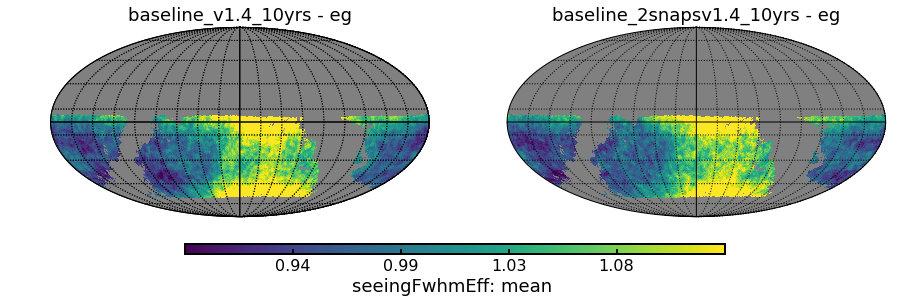

<Figure size 720x432 with 0 Axes>

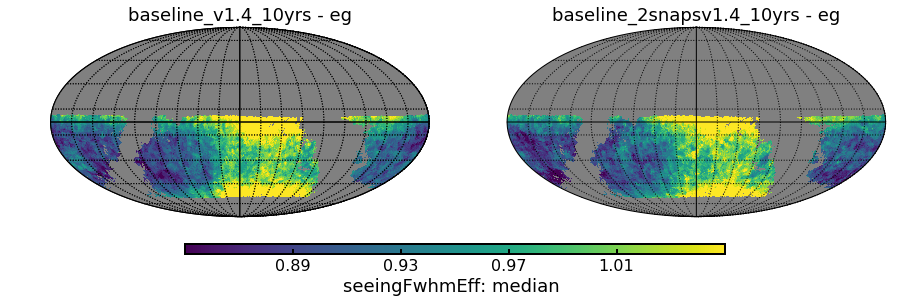

<Figure size 720x432 with 0 Axes>

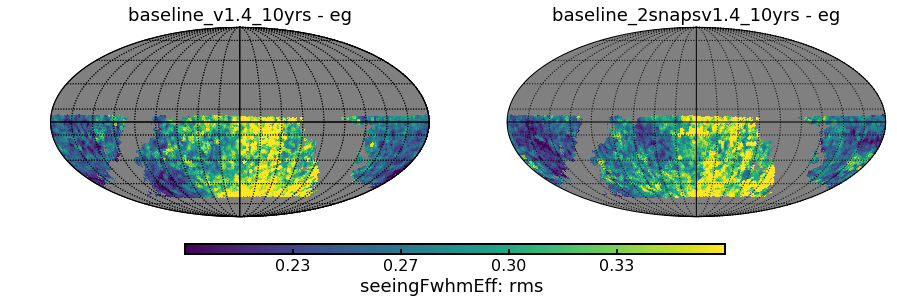

In [12]:
for stat in stats:
    
    plt.clf()
    fig, axes= plt.subplots(1,2)
    for i, dbname in enumerate( dbnames ):

        key = '%s - %s' % (dbname, stat)
        
        temp = copy.deepcopy( bundles_all[key] )
        temp.metricValues.mask[:] = eg_masks[dbname].astype(bool)
        
        if i == 0:
            in_survey_pixels = np.where( temp.metricValues.mask == False )[0]
            # find the color range
            median = np.median(temp.metricValues.data[in_survey_pixels])
            stddev = np.std(temp.metricValues.data[in_survey_pixels])

            colormin = median - 1.5 * stddev
            colormax = median + 1.5 * stddev
            nticks = 5

        plt.axes(axes[i])
        hp.mollview(temp.metricValues, flip='astro', rot=(0,0,0),
                    min=colormin, max=colormax, hold=True,
                    cbar=False, title='%s - eg' % dbname)
        hp.graticule(dpar=20, dmer=20, verbose=False)

    # set up the color bar
    increment = (colormax - colormin) / float(nticks)
    ticks = np.arange(colormin + increment, colormax, increment)

    ax = plt.gca()
    im = ax.get_images()[0]
    fig= plt.gcf()
    cbaxes = fig.add_axes([0.25, 0.38, 0.5, 0.01]) # [left, bottom, width, height]
    cb = plt.colorbar(im, orientation='horizontal',
                      ticks=ticks, format='%.2f', cax=cbaxes
                     )
    cb.set_label('%s: %s ' % (colname, stat) )
    fig.set_size_inches(15,15)
    plt.show()

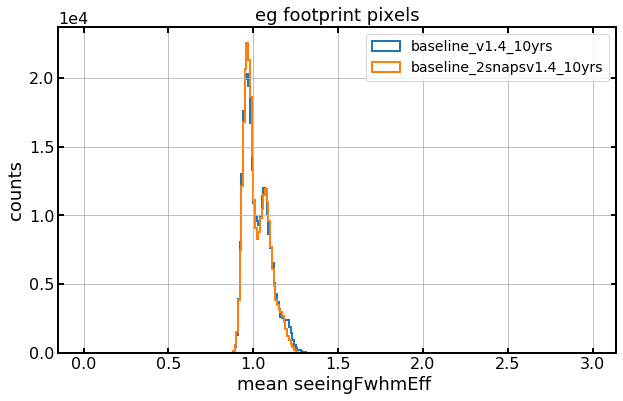

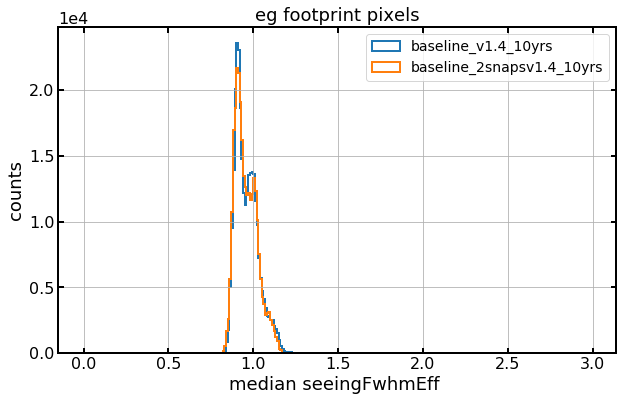

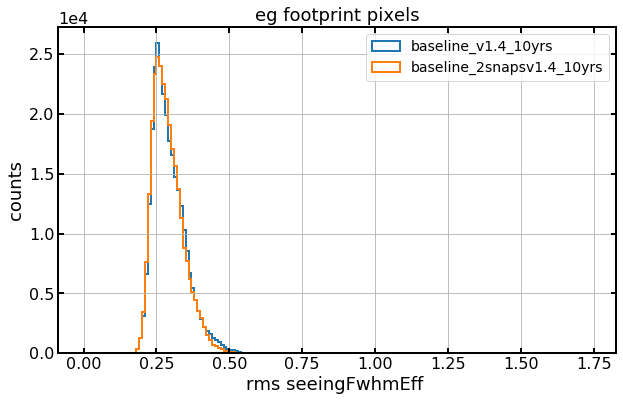

In [13]:
for stat in stats:
    if stat == 'mean' or stat == 'median':
        bins = np.arange(0, 3, 0.01)
    if stat == 'rms':
        bins = np.arange(0, 1.75, 0.01)

    plt.clf()
    for i, dbname in enumerate( dbnames ):

        key = '%s - %s' % (dbname, stat)
        in_survey_pixels = np.where( eg_masks[dbname] == False )[0]
        
        plt.hist(bundles_all[key].metricValues.data[in_survey_pixels], label=dbname, histtype='step', lw=2, bins=bins)

    plt.legend()
    plt.xlabel('%s %s ' % (stat, colname))
    plt.ylabel('counts')
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    plt.title('eg footprint pixels')
    plt.show()

okay there appear to be differences in seeing between the two versions. the mean seeing and the rms is slightly better in 2snaps vs. not, but this is not enough to account for 7.7% improvement in depth stddev that we see with baseline-2snaps

##### lets plot out the coadded depth distributions

In [14]:
depth_dir = '/global/cscratch1/sd/awan/lsst_output/post_wp_output_v1.4_-0.1cuts/bundle_data/'
ilim = 25.9

depth_bundles = {}

for dbname in dbnames:
    dbname = dbname.split('.db')[0]
    file = [f for f in os.listdir(depth_dir) if f.__contains__('depth_in_eg_%s' % dbname) and \
                f.__contains__('limi%s' % ilim)
               ]
    print(file)
    
    depth_bundles[dbname] = metricBundles.createEmptyMetricBundle()
    depth_bundles[dbname].read('%s/%s' % (depth_dir, file[0]))

['depth_in_eg_baseline_v1.4_10yrs_i-band_limi25.9_nodither_nside256.npz']
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
['depth_in_eg_baseline_2snapsv1.4_10yrs_i-band_limi25.9_nodither_nside256.npz']
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes


In [15]:
area_ppixel = hp.nside2pixarea(nside=256, degrees=True)

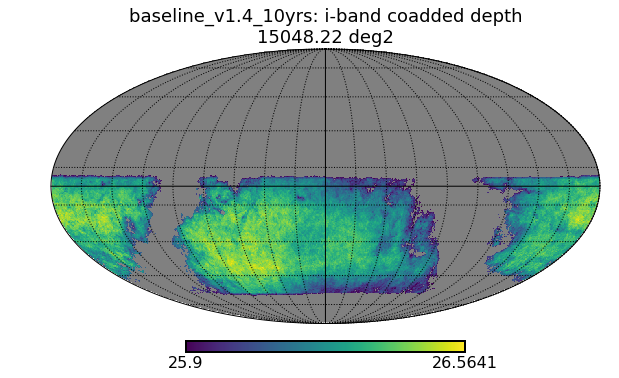

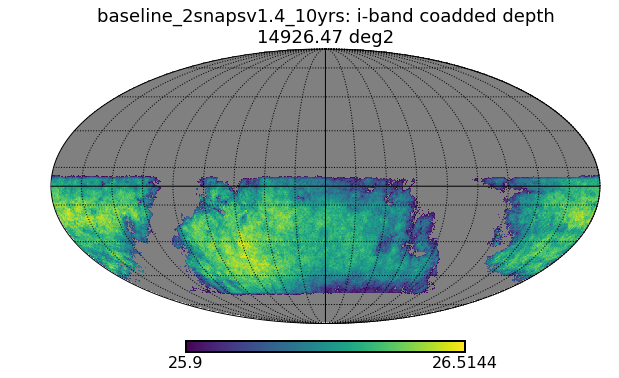

In [16]:
for dbname in depth_bundles:
    in_survey_pixels = np.where( depth_bundles[dbname].metricValues.mask == False )[0]
    hp.mollview(depth_bundles[dbname].metricValues, flip='astro', rot=(0,0,0),
                min=None, max=None, hold=True,
                cbar=True, title='%s: i-band coadded depth\n%.2f deg2' % (dbname , len(in_survey_pixels) * area_ppixel))
    hp.graticule(dpar=20, dmer=20, verbose=False)
    plt.show()

In [17]:
min_all, max_all = 1000, -1000
for dbname in depth_bundles:
    in_survey_pixels = np.where( depth_bundles[dbname].metricValues.mask == False )[0]
    min_all = min( [ min_all, min(depth_bundles[dbname].metricValues.data[in_survey_pixels]) ])
    
    max_all = max( [ max_all, max(depth_bundles[dbname].metricValues.data[in_survey_pixels]) ])
    
print(min_all, max_all)

25.90000669634359 26.566152282770027


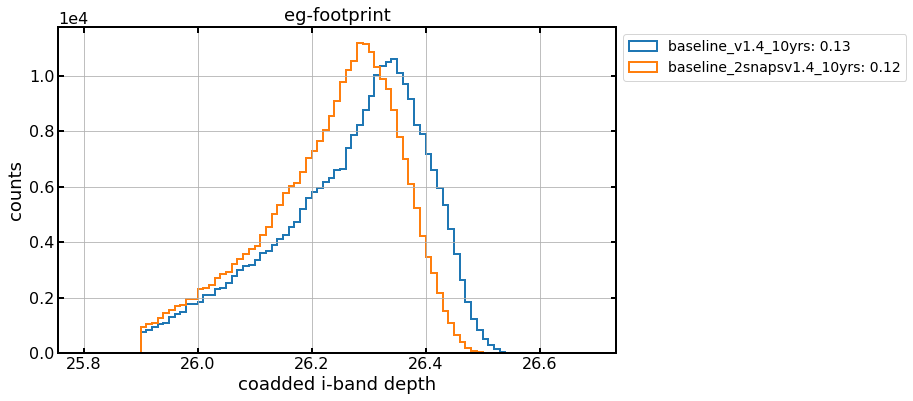

In [18]:
bins = np.arange(25.8, 26.7, 0.01)

plt.clf()

for dbname in depth_bundles:
    in_survey_pixels = np.where( depth_bundles[dbname].metricValues.mask == False )[0]
    stddev = np.std(depth_bundles[dbname].metricValues.data[in_survey_pixels])
    plt.hist( list(depth_bundles[dbname].metricValues.data[in_survey_pixels]), label='%s: %.2f' % (dbname, stddev), histtype='step', lw=2, bins=bins)

plt.xlabel('coadded i-band depth')
plt.ylabel('counts')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.title('eg-footprint') 

plt.legend(bbox_to_anchor=(1,1))
plt.show()

okay the depth distribution is narrower in 2snaps => stddev is smaller.

lets check the eg-footprint to be sure

In [19]:
for dbname in depth_bundles:
    print(  '%s: masks match: %s' % (dbname, (eg_masks[dbname].astype(bool) == depth_bundles[dbname].metricValues.mask).all() ))

baseline_v1.4_10yrs: masks match: True
baseline_2snapsv1.4_10yrs: masks match: True


##### lets look at the single-visit depth  in eg-footprint

In [20]:
five_sigma_path = '/global/cscratch1/sd/awan/lsst_output/post-wp_v1.4_five-sigma-depth/'

five_sigma_depth_bundles = {}

for dbname in dbnames:
    dbname = dbname.split('.db')[0]
    file = [f for f in os.listdir(five_sigma_path) if f.__contains__(dbname) and \
               f.__contains__('y10')
               ]
    print(file)
    
    five_sigma_depth_bundles[dbname] = metricBundles.createEmptyMetricBundle()
    five_sigma_depth_bundles[dbname].read('%s/%s' % (five_sigma_path, file[0]))

['baseline_v1.4_10yrs_mean-fiveSigmaDepth_y10_iband_nside256.npz']
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
['baseline_2snapsv1.4_10yrs_mean-fiveSigmaDepth_y10_iband_nside256.npz']
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes


In [21]:
min_all, max_all = 1000, -1000
for dbname in depth_bundles:

    eg_pixels = np.where( depth_bundles[dbname].metricValues.mask == False )[0]
    
    min_all = min( [ min_all, min(five_sigma_depth_bundles[dbname].metricValues.data[eg_pixels]) ])
    max_all = max( [ max_all, max(five_sigma_depth_bundles[dbname].metricValues.data[eg_pixels]) ])
    
print(min_all, max_all)

22.825885663373658 23.480357213748523


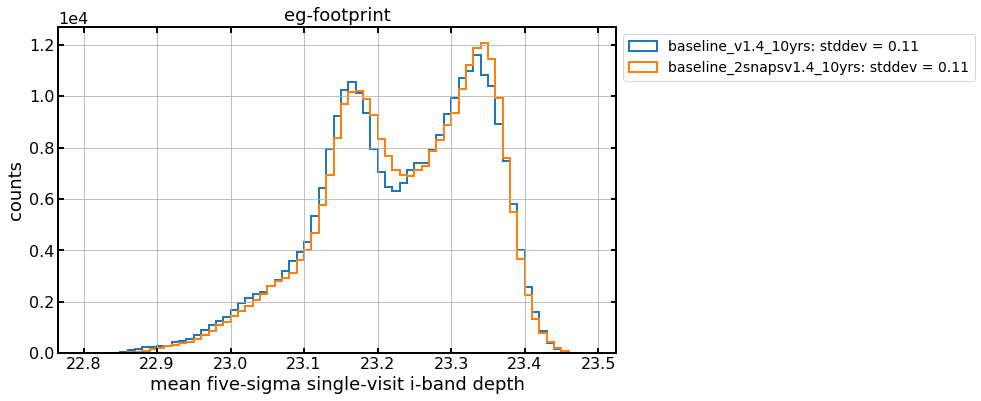

In [22]:
bins = np.arange(22.8, 23.5, 0.01)

plt.clf()

for dbname in depth_bundles:
    eg_pixels = np.where( depth_bundles[dbname].metricValues.mask == False )[0]
    
    stddev = np.std(five_sigma_depth_bundles[dbname].metricValues.data[eg_pixels])
    plt.hist( list(five_sigma_depth_bundles[dbname].metricValues.data[eg_pixels]), label='%s: stddev = %.2f' % (dbname, stddev), histtype='step', lw=2, bins=bins)

plt.xlabel('mean five-sigma single-visit i-band depth')
plt.ylabel('counts')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.title('eg-footprint')

plt.legend(bbox_to_anchor=(1,1))
plt.show()

okay the single-visit depth distribution is basically the same between the two dbs

#### lets look at the nvisits for this band, then

In [23]:
 # consider only non-DD visits
sqlconstraint = ' note not like "DD%"'
sqlconstraint += ' and filter=="i"'

resultsDb = db.ResultsDb(outDir=outdir)

nvisits_all = {}
for dbname in dbnames:
    bundles = {}
    
    dbpath = '%s/%s.db' % (dbdir, dbname)

    opsdb = db.OpsimDatabase(dbpath)
    # set up slicer
    slicer = slicers.HealpixSlicer(lonCol='fieldRA', latCol='fieldDec',
                                   latLonDeg=opsdb.raDecInDeg, nside=nside, useCache=False)
    
    # set up the counts metric
    metric = metrics.CountMetric('observationStartMJD', metricName='Nvisits')
    
    bundles['nvisits'] = metricBundles.MetricBundle(metric, slicer, sqlconstraint)
    
    # set up the group.
    grp = metricBundles.MetricBundleGroup(bundles, opsdb, outDir=outdir,
                                          resultsDb=resultsDb, saveEarly=False)
    grp.runAll()

    for key in bundles:
        nvisits_all[ dbname] = copy.deepcopy(bundles['nvisits'])

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Querying database SummaryAllProps with constraint  note not like "DD%" and filter=="i" for columns ['fieldRA', 'fieldDec', 'observationStartMJD']
Found 437227 visits
Running:  ['nvisits']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Querying database SummaryAllProps with constraint  note not like "DD%" and filter=="i" for columns ['fieldRA', 'fieldDec', 'observationStartMJD']
Found 403918 visits
Running:  ['nvisits']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [24]:
min_all, max_all = 1000, -1000
for dbname in nvisits_all:

    eg_pixels = np.where( depth_bundles[dbname].metricValues.mask == False )[0]
    
    min_all = min( [ min_all, min(nvisits_all[dbname].metricValues.data[eg_pixels]) ])
    max_all = max( [ max_all, max(nvisits_all[dbname].metricValues.data[eg_pixels]) ])
    
print(min_all, max_all)

92.0 237.0


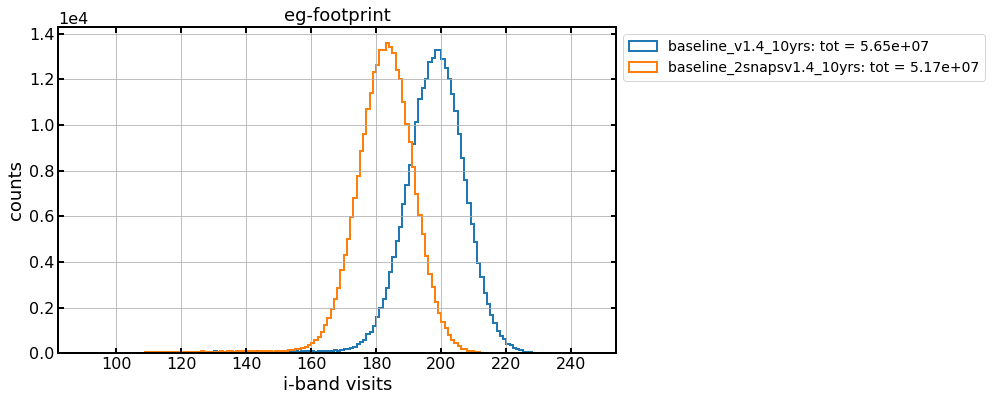

In [25]:
bins = np.arange(90., 247., 1.0)

plt.clf()

for dbname in nvisits_all:
    eg_pixels = np.where( depth_bundles[dbname].metricValues.mask == False )[0]
    total = np.sum(nvisits_all[dbname].metricValues.data[eg_pixels])
    plt.hist( list(nvisits_all[dbname].metricValues.data[eg_pixels]), label='%s: tot = %.2e' % (dbname, total), histtype='step', lw=2, bins=bins)

plt.xlabel('i-band visits')
plt.ylabel('counts')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.title('eg-footprint')

plt.legend(bbox_to_anchor=(1,1))
plt.show()

##### okay we have more visits in the baseline than in 2snaps. the question now is whether the decrease in visits is the release for improved stddev with 2snaps

lets look at the nvisits skymaps

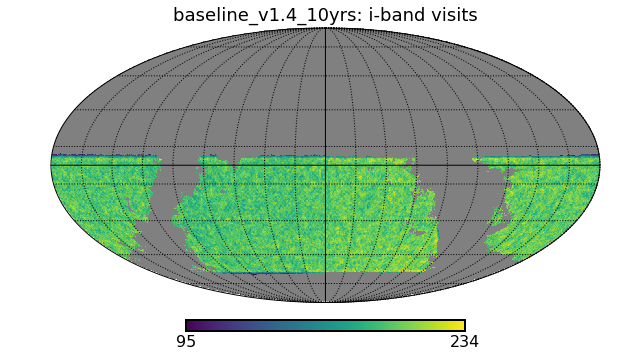

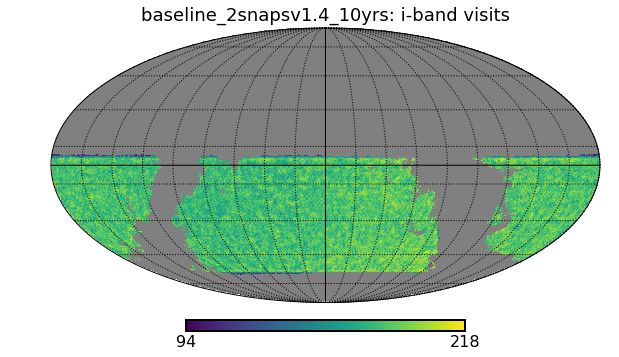

In [26]:
for dbname in depth_bundles:
    
    temp = copy.deepcopy(nvisits_all[dbname])
    temp.metricValues.mask[:] = depth_bundles[dbname].metricValues.mask
    
    hp.mollview(temp.metricValues, flip='astro', rot=(0,0,0),
                min=None, max=None, hold=True,
                cbar=True, title='%s: i-band visits' % (dbname))
    hp.graticule(dpar=20, dmer=20, verbose=False)
    plt.show()

okay we really actually care about the fluctuations in the nvisits (since the stddev is of the depth across the survey)

baseline_v1.4_10yrs: mean nvisits: 196.98


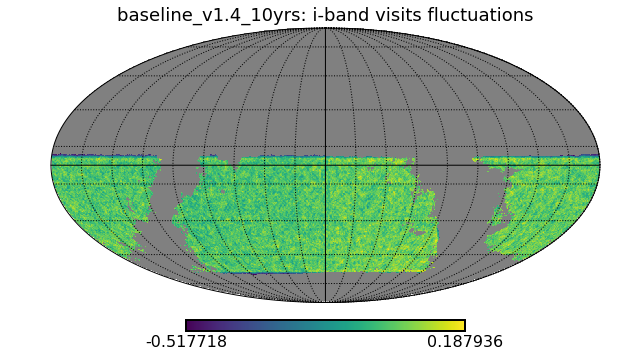

baseline_2snapsv1.4_10yrs: mean nvisits: 181.81


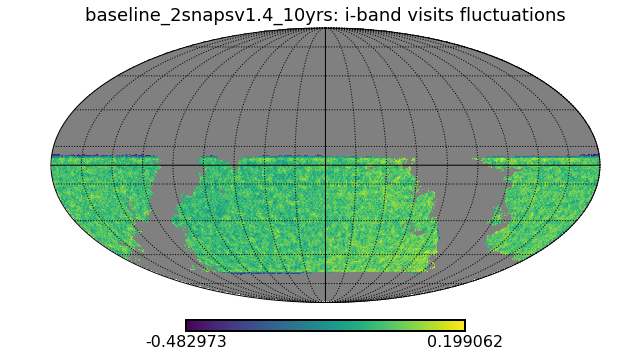

In [27]:
for dbname in depth_bundles:
    
    temp = copy.deepcopy(nvisits_all[dbname])
    temp.metricValues.mask[:] = depth_bundles[dbname].metricValues.mask
    
    in_survey = np.where( temp.metricValues.mask == False )[0]
    mean_nvisits = np.mean(temp.metricValues.data[in_survey])
    temp.metricValues.data[in_survey] -= mean_nvisits
    
    temp.metricValues.data[in_survey] /= mean_nvisits
    
    print('%s: mean nvisits: %.2f' % (dbname, mean_nvisits) )
    
    hp.mollview(temp.metricValues, flip='astro', rot=(0,0,0),
                min=None, max=None, hold=True,
                cbar=True, title='%s: i-band visits fluctuations' % (dbname))
    hp.graticule(dpar=20, dmer=20, verbose=False)
    plt.show()

In [28]:
print('the mean nvisits has changed by %.2f%% ' % (100 * (181.81 - 196.98) /  196.98) )

the mean nvisits has changed by -7.70% 


In [29]:
print('the depth stddev has changed by %.2f%% ' % (100 * (0.12 - 0.13) /  0.13) )

the depth stddev has changed by -7.69% 


does this make sense?